## Towards comparing the signal-to-noise in different filter widths

## A detailed comparison of the UVES and Gemini sky spectra

How well do they agree?  Should we be using the UVES spectra instead of the Gemini sky spectra?

What sky lines are visible in Gemini, since seem to be way more visible in the UVES spectra than Gemini?

What is the change in the sky flux in different filter widths, in both the Gemini and UVES sky background spectra?

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from astropy.io import fits

### determining the sky background

#### Gemini Sky Background data  
(http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/skybg_50_10.dat)

sky background 0.3-1.0um

DARK optical sky - 50%ile conditions (day 7)

AM=1.0

derived from (reverse engineered ESO model) sky spectrum plus constant slope to match assumed photometric background (from von Hippel model.

#### UVES Sky Background data  
(http://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html)

These spectra were selected for a bunch of criteria, including:
"minimal moon contamination fractional lunar illumination < 0.05 and moon distance > 90 deg)"

That means that the scaled Gemini spectra is better (unless we also scale the UVES spectra)

Note that there are a bunch of column leaks in the UVES spectra -- make sure take that into account if end up using the UVES spectra for line identification!
>The REDU (red upper) CCD suffered from a leaking column causing broad quasi-emission in the echelle order. These features have been easily recognized due to their known position and atypical width. They are marked by squared crosses in the plots.

In particular, leaky columns at:<br>
6341 Angstroms<br>
6407 Angstroms<br>
6575 Angstroms<br>
6545 Angstroms<br>
66l5 Angstroms<br>
6689 Angstroms<br>


#### Compare
Want to compare the UVES and Gemini sky spectra.  To do this need to convert to the same units:  photon / s / cm^2 / arcsec^2 / nm.

Gemini is in: photon / s / **m^2** / arcsec^2 / nm 

* (m / 100cm) ^2

UVES is in: 1e-16 **erg** / s / cm^2 / arcsec^2 / **Angstrom**

* 1 photon / ( h c / lambda ) erg
* 10 Angstrom / nm

In [182]:
## from reading the Gemini and UVES data in raw
## get them both into units of ph / s / nm / cm**2 / arcsec**2
#wavelen_GEM = wavelen_G
#flux_GEM = flux_G * (1/100.**2) # / m**2 --> / cm **2
#wavelen_UVES = wavelen_U / 10.  # Angs --> nm
#flux_UVES = flux_U *10**-16 * ((wavelen_UVES*10**-9)/(const.h.to('erg s').value * const.c.to('m/s').value)) * 10. # erg --> photon and / Ang --> / nm

In [78]:
def getBackgroundGemini(start,end,machine,plot=False):
    # Returns the total background flux in the wavlength interval supplied i.e. returns (flux)*(wavlength interval) 
    wavelength = []
    flux = []
    
    if machine=='chinook':
        geminiloc='/Users/lokhorst/Documents/Eagle/Gemini_skybackground.dat'
    elif machine=='coho':
        geminiloc='/Users/deblokhorst/Documents/Dragonfly/HalphaScripts/Gemini_skybackground.dat'
    
    with open(geminiloc,'r') as f:  #wavelength in nm, flux in phot/s/nm/arcsec^2/m^2
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                wavelength.append(tmp[0])
                flux.append(tmp[1])
                
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
    
    # for plottingn purposes:
    # wavelength[start_ind:end_ind],flux[start_ind:end_ind]
    
    # if spacings are not even, need to add element by element
    total=0
    for index in np.arange(start_ind,end_ind):
      #  print index,index+1
      #  print total
        total = total+(flux[index]*(wavelength[index+1]-wavelength[index]))
        
    # if spacings are even, can just take the average of the flux array and times it by the total bandwidth
   # np.mean(flux[start_ind:end_ind])*(wavelength[end_ind]-wavelength[start_ind])
    
   # print('start index and end index: %s and %s'%(start_ind,end_ind))
   # print(wavelength[start_ind:end_ind]-wavelength[start_ind+1:end_ind+1])
    if plot==True:
        plt.plot(wavelength[start_ind-100:end_ind+100],flux[start_ind-100:end_ind+100])
        top = max(flux[start_ind-100:end_ind+100])
        plt.plot([start,start,end,end,start],[0,top,top,0,0])
        plt.show()
        
    return total,wavelength[start_ind:end_ind],flux[start_ind:end_ind]

In [226]:
def getBackgroundUVES(start,end,machine,plot=False):
    
    #start = start*10
    #end = end*10
    
    def getUVESBackground(filename):
        hdulist = fits.open(filename)
        flux = hdulist[0].data
    
        CRPIX1 = hdulist[0].header['CRPIX1']
        CRVAL1 = hdulist[0].header['CRVAL1']
        CDELT1 = hdulist[0].header['CDELT1']
        #print(CRPIX1,CRVAL1,CDELT1)
        hdulist.close()
        
        begin = CRVAL1 - CRPIX1*CDELT1   
        end = begin + len(flux)*CDELT1
        wavelength = np.arange(begin,end,CDELT1)
        #print(len(wavelength),len(flux))
        return wavelength,flux

    # Returns the total background flux in the wavlength interval supplied i.e. returns (flux)*(wavlength interval) 
    wavelength = []
    flux = []
    
    filename1 = "fluxed_sky_580U.fits"
    filename2 = "fluxed_sky_860L.fits"


    if machine=='coho':
        uvesloc = '/Users/deblokhorst/Dropbox/UVES_Sky_Background/UVES_sky_all/'
    elif machine =='chinook':
        uvesloc = '/Users/lokhorst/Dropbox/UVES_Sky_Background/UVES_sky_all/'
    else:
        print 'No machine specified!'
    
    wavelength_UVES1,flux_UVES1=getUVESBackground(uvesloc+filename1)
    wavelength_UVES2,flux_UVES2=getUVESBackground(uvesloc+filename2)

    if len(wavelength_UVES2)==(len(flux_UVES2)+1):
        print('wavelength array is one element longer than the flux array.  Shortening the wavelength array.')
        wavelength_UVES2 = wavelength_UVES2[0:-1]
        
    wavelength = np.append(wavelength_UVES1[wavelength_UVES1<6700.],wavelength_UVES2[wavelength_UVES2>6700.])
    flux = np.append(flux_UVES1[wavelength_UVES1<6700.],flux_UVES2[wavelength_UVES2>6700.])
        
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    # convert the units to nm and ph / s / nm / m**2 / arcsec**2
    wavelength = wavelength / 10.  
        # Angs --> nm
    flux = flux *10**-16 * ((wavelength*10**-9)/(const.h.to('erg s').value * const.c.to('m/s').value)) * 10. * (100/1)**2 
        # (erg --> photon) and (/ Ang --> / nm) and (/ cm**2 --> / m**2)
        
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
        
    # if spacings are not even, need to add element by element
    total=0
    for index in np.arange(start_ind,end_ind):
        total = total+(flux[index]*(wavelength[index+1]-wavelength[index]))
        
    if plot==True:
        plt.plot(wavelength[start_ind-100:end_ind+100],flux[start_ind-100:end_ind+100])
        top = max(flux[start_ind-100:end_ind+100])
        plt.plot([start,start,end,end,start],[0,top,top,0,0])
        plt.show()
        
    return total,wavelength[start_ind:end_ind],flux[start_ind:end_ind]

In [227]:
def loadUVESlinelists(machine='coho'):
    if machine=='coho':
        homedir = '/Users/deblokhorst'
    elif machine =='chinook':
        homedir = '/Users/lokhorst'

    # UVES identified line lists
    line_wavelength = []
#    with open(homedir+'/Dropbox/UVES_Sky_Background/UVES_ident/gident_437.dat','r') as f:
#        for line in f:
#            if line[0]!='#' and len(line)>5:
#                tmp = line.split()
#                line_wavelength.append(tmp[1])
#    with open(homedir+'/Dropbox/UVES_Sky_Background/UVES_ident/gident_580L.dat','r') as f:
#        for line in f:
#            if line[0]!='#' and len(line)>5:
#                tmp = line.split()
#                line_wavelength.append(tmp[1])
    with open(homedir+'/Dropbox/UVES_Sky_Background/UVES_ident/gident_580U.dat','r') as f:
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                line_wavelength.append(tmp[1])
    with open(homedir+'/Dropbox/UVES_Sky_Background/UVES_ident/gident_860L.dat','r') as f:
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                line_wavelength.append(tmp[1])
    line_wavelength = np.array(line_wavelength,'d')
    
    return line_wavelength


In [31]:
def datareduce(data,factor,method = 'average'):
    if len(data)%factor != 0:
        print('Output data must have a integer number of cells: cannot reduce image pixels by a factor %i'%factor)
        return None
    data = np.split(data,len(data)/factor)
    data = np.sum(data,axis=-1)
    if method == 'average':
        data = data/np.float(factor)
    return data

In [232]:
plt.style.use('seaborn-dark-palette')
plt.style.use('ggplot')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)


In [268]:
## compare spectral resolution of Gemini vs UVES sky spectra

start_1 = 656.
end_1 = 658.
total_G,wavelen_G,flux_G = getBackgroundGemini(start_1,end_1,machine,plot=False);
total_U,wavelen_U,flux_U = getBackgroundUVES(start_1,end_1,machine,plot=False);

print 'A couple example of wavelength points for Gemini: %s,%s,%s' %(wavelen_G[0],wavelen_G[1],wavelen_G[2])
print 'Delta wavelength for Gemini: %s, %s' %(wavelen_G[2]-wavelen_G[1],wavelen_G[1]-wavelen_G[0])
print 'A couple example of wavelength points for UVES: %s,%s,%s' %(wavelen_U[0],wavelen_U[1],wavelen_U[2])
print 'Delta wavelength for UVES: %s, %s' %(wavelen_U[2]-wavelen_U[1],wavelen_U[1]-wavelen_U[0])
print ''
print 'Fraction higher resolution of UVES than Gemini is: %.1f' %\
        ((wavelen_G[2]-wavelen_G[1])/(wavelen_U[2]-wavelen_U[1]))

wavelength array is one element longer than the flux array.  Shortening the wavelength array.
A couple example of wavelength points for Gemini: 656.1,656.37,656.63
Delta wavelength for Gemini: 0.26, 0.27
A couple example of wavelength points for UVES: 655.998354,656.001836,656.005318
Delta wavelength for UVES: 0.00348199999996, 0.00348199999996

Fraction higher resolution of UVES than Gemini is: 74.7


wavelength array is one element longer than the flux array.  Shortening the wavelength array.
Gemini and UVES total flux of sky background within 650.0 nm and 670.0 nm: 	 9.722518, 7.41550709974
24
5720
wavelength array is one element longer than the flux array.  Shortening the wavelength array.
Gemini and UVES total flux of sky background, CWL 659.9 and bandwidth 3.0: 	 1.387259, 0.964102215584
wavelength array is one element longer than the flux array.  Shortening the wavelength array.
Gemini and UVES total flux of sky background, CWL 659.9 and bandwidth 0.8: 	 0.378483, 0.257818080354


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


wavelength array is one element longer than the flux array.  Shortening the wavelength array.
Gemini and UVES total flux of sky background, CWL 656.3 and bandwidth 3.0: 	 1.52495, 1.39467364795
wavelength array is one element longer than the flux array.  Shortening the wavelength array.
Gemini and UVES total flux of sky background, CWL 656.3 and bandwidth 0.8: 	 0.383995, 0.33251686463
[22.0, 21.1, 20.5, 20.0, 19.5, 19.0, 18.6]


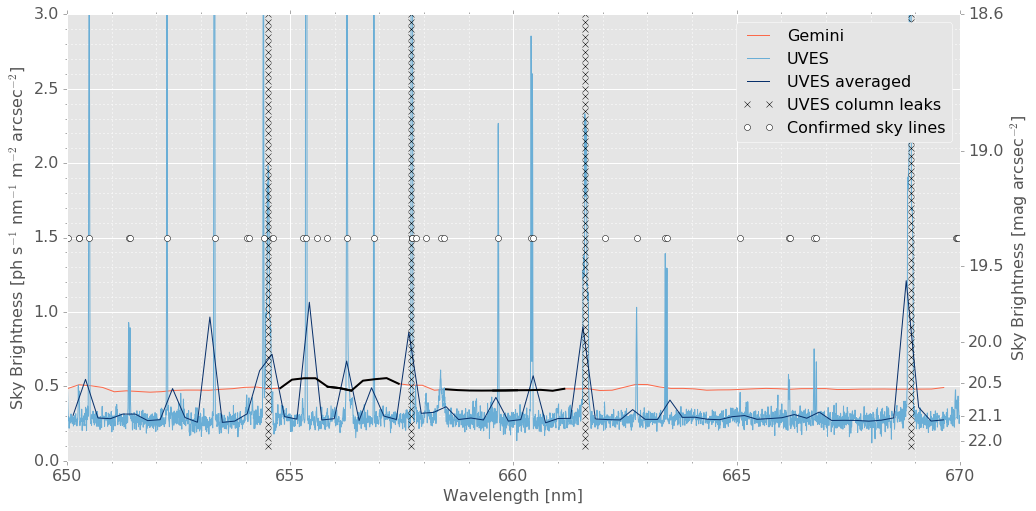

In [262]:
machine = 'coho'

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

reds = plt.get_cmap("Reds")
blues = plt.get_cmap("Blues")

# Start off the plot with the basic curves
start_1 = 650.
end_1 = 670.
total_G,wavelen_G,flux_G = getBackgroundGemini(start_1,end_1,machine,plot=False);
total_U,wavelen_U,flux_U = getBackgroundUVES(start_1,end_1,machine,plot=False);
print 'Gemini and UVES total flux of sky background within %s nm and %s nm: \t %s, %s'%\
        (start_1,end_1, total_G, total_U)

f, ax = plt.subplots(1,1,figsize = (16,8))
ax.plot(wavelen_G,flux_G,label='Gemini',color=reds(0.5))
ax.plot(wavelen_U,flux_U,label='UVES',color=blues(0.5))

print len(flux_U)%40
print len(flux_U[:-24])
factor=80
lim = -1. * (len(flux_U)%factor)
fluxsum = datareduce(flux_U[:lim],factor)
wavelensum = datareduce(wavelen_U[:lim],factor)
ax.plot(wavelensum,fluxsum,label='UVES averaged',color=blues(1.0))


# Highlight the curves that fall within different filterwidths
def emphasize(center,bandwidth,machine,plotUVES=False,yoffset = 0): 
    start = center - bandwidth/2.
    end = center + bandwidth/2.
    total_G2,wavelen_G2,flux_G2 = getBackgroundGemini(start,end,machine,plot=False)
    ax.plot(wavelen_G2,flux_G2+yoffset,'k',linewidth=2)
    total_U2,wavelen_U2,flux_U2 = getBackgroundUVES(start,end,machine,plot=False)
    if plotUVES:
        factor=6
        lim = -1. * (len(flux_U2)%factor)
        ax.plot(datareduce(wavelen_U2[:lim],factor),datareduce(flux_U2[:lim],factor)+yoffset,'k',linewidth=2)
    print 'Gemini and UVES total flux of sky background, CWL %s and bandwidth %s: \t %s, %s'%\
            (center,bandwidth, total_G2, total_U2)
        
emphasize(659.9,3.,machine,yoffset = 0);
emphasize(659.9,0.8,machine,yoffset = 0);
emphasize(656.3,3.,machine,yoffset = 0);
emphasize(656.3,0.8,machine,yoffset = 0);

## Add in the leaky columns to show where should ignore the data
leakycolumns = [6341, 6407, 6577, 6545, 6616, 6689]
ymin,ymax = 0.1,5.1; steps = 0.05
for place in leakycolumns:
    ax.plot([place/10.]*int((ymax-ymin)/steps), np.arange(ymin,ymax,steps), 'kx');
ax.plot(0,0,'kx',label='UVES column leaks')

## Add in the confirmed lines to show where should definitely pay attention to the data
line_wavelengths = loadUVESlinelists()
for line in line_wavelengths:
    ax.plot(line/10.,1.5,'wo')
ax.plot(0,0,'wo',label='Confirmed sky lines')

ax.set_xlim(start_1,end_1)
ax.set_ylim(0,3)
ax.set_ylabel(r'Sky Brightness [ph s$^{-1}$ nm$^{-1}$ m$^{-2}$ arcsec$^{-2}$]')
ax.set_xlabel('Wavelength [nm]')
ax.legend(fancybox=True)


ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor',linestyle=':', color='w', linewidth=1.0)


Jy = 10**-23
c = 3.*10**8 # m / s #const.c.to('m/s').value
h = const.h.to('erg s').value
nm = 10**-9

def SB_photonscgs_to_ABmagarcsec(sb_ph_m, wavelength): # sb in ph/s/nm/m**2/arcsec**2, wavelength in nm
    sb = sb_ph_m * (h * c / (wavelength*10**-9)) * (1./100.)**2
    return -2.5*np.log10(sb * (wavelength*10**-9)**2 /(3631.*Jy * nm * c)) # sb in erg/s/nm/cm**2/arcsec**2

ax2 = ax.twinx()
ax2.set_ylabel(r'Sky Brightness [mag arcsec$^{-2}$]')
ax2.set_ylim(0,3)
yticks = [0.13,0.3,0.52,0.8,1.31,2.08,3.0]
print [round(SB_photonscgs_to_ABmagarcsec(ytick,660.),1) for ytick in yticks]
ax2.set_yticks(yticks)
ax2.set_yticklabels([round(SB_photonscgs_to_ABmagarcsec(ytick,660.),1) for ytick in yticks])
ax2.grid()

NOTE:

I was trying to change the AB magnitude for different bandwidths by multiplying the input surface brightness, sb_ph_m, by the bandwidth (like 10nm or whatever).  This is NOT CORRECT because the reference flux for the AB mag sytem is *per nm* so if we change the bandwidth of the input surface brightness (so it would be / 10nm instead of /nm if we multiplied by 10), we have to also change the bandwidth of the reference flux so that the units are still correct!  If you do that, the change in bandwidth just cancels out.

**I.e. the sky brightness in mag/arcsec^2 is independant of bandwidth since it is AB so the reference is the same no matter what band you pick.**

### Conclusions:

Though the UVES spectrum is much higher resolution (75x higher) and is higher signal-to-noise, which makes it more sensitive to sky lines, the two spectra are consistent with one another.

Further, they are consistent with the night sky conditions when they were taken (the UVES spectra was taken on only the darkest nights, whereas the Gemini spectra is scaled to match the 50%-ile conditions of the observing nights), so the Gemini spectra is expected to be brighter.

Have demonstrated the sky background calculation within variable filter widths in preparation for using it to calculate surface brightnesses.

Have demonstrated that the Gemini sky brightness spectra is a reasonable approximation of the sky brightness where the emission lines are averaged over large filter widths.

Further steps:
- take the Gemini spectra sky flux in the filterwidth and use them to produce signal-to-noise estimates
- use the UVES spectra to calculate the sky flux and scale it appropriately with moon brightness, etc, to do a better simulation of the effects of avoiding sky lines.

In [270]:
ratelist = [[1,2,3],[9,8,7]]
for r,rating in enumerate(ratelist):
    print r,rating
    

0 [1, 2, 3]
1 [9, 8, 7]
